## Algoritmos genéticos

- Tipo de algoritmo evolucionário
- Busca reproduzir o comportamento biológico
- Populações de indivíduos são criadas e submetidas a operações genéticas
 - Seleção
 - Recombinação / Crossover
 - Mutação
 - Elitismo
 
<img src="images/alg_gen.png" width = 600>

### Fenótipo x Genótipo
- Fenótipo: Representação visual de um estado
- Genótipo: Representação binária de um estado

<img src = "images/fen_gen.png" width = 600>

### BitSet
- Estrutura de dados auxiliar para representar os cromossomos de forma binária

In [1]:
import numpy as np

# Classe para manutenção de dados no formato de conjunto de bits
class BitSet:
    
    def __init__(self, size):
        '''
        Construtor
        Args:
            - size: tamanho do bitset
        '''
        # Preencher um array [size] com False
        self.bits = np.full(size, False)
        
    def __repr__(self):
        '''Definir o que aparecerá quando um objeto for printado'''
        return (f"{self.bits*1}")
        
    def get(self, index):
        '''
        Retornar o bit da posição 'index'
        Args:
            - index: posição do bit
        '''
        return self.bits[index]
    
    def set_(self, index, value):
        '''
        Substitui o bit da posição 'index' pelo 'value'
        Args:
            - index: posição a ser substituída
            - value: valor a ser adicionado na posição 'index'
        '''
        self.bits[index] = value
        
    def flip(self, index):
        '''
        Inverte o bit da posição 'index'
        Args:
            - index: índice do bit a ser invertido
        '''
        self.bits[index] = not self.bits[index]
        
    def debug(self):
        '''
        Printar os bits
        '''
        print(self.bits)

In [2]:
b = BitSet(10)
b.flip(3)
b.set_(1, True)
b.debug()

[False  True False  True False False False False False False]


### Cromossomos
- Cada cromossomo é um indivíduo que possui seu próprio genótipo e fenótipo

PARA ESSE EXERCÍCIO cada indivíduo terá 10 genes, os 5 primeiros representado, de forma binária, a variável x (o último bit será o sinal) e os 5 genes subsequentes representam a variável y
<img src="images/individuo.png" width=400>

In [3]:
class Chromossome:
    
    def __init__(self, x = None, y = None):
        '''
        Construtor
        Atribui o genótipo de x e y ao cromossomo
        Args:
            - x: valor de x
            - y: valor de y
        '''
        x = np.random.randint(-15, 16) if x is None else x
        y = np.random.randint(-15, 16) if y is None else y
        
        self.genes = Chromossome.get_genotype(x, y)
        self.score = np.inf
        
    def __repr__(self):
        '''Apresentar os genes e a pontuação quando utilizar print(Chromossome)'''
        return (f'(Gene: {self.genes}, Score: {self.score:.3f})')
    
    def __lt__(self, other):
        ''' Ordenar em ordem decrescente'''
        return self.score > other.score
    
    @staticmethod
    def to_binary(variable):
        '''
        Converte o fenótipo (decimal) em genótipo(binário)
        '''
        variable = "{:05b}".format(variable)
        signal = 1 if variable[0] == "-" else 0
        variable = variable[1:]
        variable += str(signal)
        
        return variable

    @staticmethod
    def get_genotype(x, y):
        '''
        Transforma os fenótipos em genótipos 
        '''
        bits = BitSet(10)

        x_genotype = Chromossome.to_binary(x)
        y_genotype = Chromossome.to_binary(y)
        xy_binary = x_genotype + y_genotype
        
        for i in range(10):
            bits.set_(i, xy_binary[i] == '1')

        return bits

    @staticmethod
    def get_fenotype(genes):
        '''
        Transforma os valores binários dos genes em decimais 
        '''
        # XXXXX YYYYY (5 bits to each variable: 4 for value and 1 for sign pos/neg)
        # 01234 56789 (bits are indexed from left to right)
        # 8421K 8421K (bits on indices 4 and 9 represent the variables sign, i.e.
        #              0 represents a positive and 1 represents a negative value)

        x = (8 * genes.get(0) + 4 * genes.get(1) +
             2 * genes.get(2) + 1 * genes.get(3))

        if (genes.get(4) == 1):
            x *= -1

        y = (8 * genes.get(5) + 4 * genes.get(6) +
             2 * genes.get(7) + 1 * genes.get(8))

        if (genes.get(9) == 1):
            y *= -1

        return x, y

In [4]:
c = Chromossome(10,-5)
d = Chromossome()

print(c)
print(d)
print(f"Fenotype: {Chromossome.get_fenotype(d.genes)}")

(Gene: [1 0 1 0 0 0 1 0 1 1], Score: inf)
(Gene: [1 1 1 0 0 0 1 1 1 1], Score: inf)
Fenotype: (14, -7)


### Problema
- O problema a ser solucinado consiste em encontrar os valores de x e y que minimizem (idealmente 0) a seguinte função:

${x^2 + y^2}$

- Definir função: ${x^2 + y^2}$
- Submeter cromossomos à função
- Definir pontuação: Quanto mais próximo de 0 o resultado da função, mais próximo de 1 (100%) a pontuação
- Submeter cromossomos à pontuação
- Calcular média da função para uma população
- Calcular média da pontuação para uma população

In [5]:
class Problem:

    @staticmethod
    def function(x, y):
        '''
        Função avaliada
        '''
        return x**2 + y**2
    
    @staticmethod
    def score(x, y):
        '''
        Função a ser minimizada
        '''
        return abs(Problem.function(x, y))

    @staticmethod
    def score_chromossome(chromossome):
        '''
        Transforma o genótipo em fenótipo e calcula o valor da função
        '''
        x, y = Chromossome.get_fenotype(chromossome.genes)
        return Problem.score(x, y)

    @staticmethod
    def score_average(population):
        '''
        Pontuação média da população
        '''
        avg = 0
        for chromossome in population:
            avg += Problem.score_chromossome(chromossome)
        avg /= len(population)
        return avg
    
    @staticmethod
    def update_chromossome_score(chromossome):
        '''
        Atualiza pontuação do cromossomo
        '''
        genes_aux = Chromossome.get_fenotype(chromossome.genes)
        x = genes_aux[0]
        y = genes_aux[1]
        chromossome.score = Problem.score(x,y)

### Utils
Funções genéricas para auxílio do processamento

In [6]:
class GeneticUtils:
    
    @staticmethod
    def find_best_chromossome(population):
        '''
        Retorna o melhor cromossomo
        '''
        population.sort()
        return population[-1]

    @staticmethod
    def find_worst_chromossome(population):
        '''
        Retorna o pior cromossomo
        '''
        population.sort()
        return population[0]

    @staticmethod
    def roulette(population):
        '''
        Retorna probabilidades de cada indivíduo ser selecionado
        '''
        population_scores = [chromossome.score for chromossome in population]
        population_scores = np.array(population_scores)

        # Calculando aptidão
        fitness = 1 / (population_scores + 1)
        total_fitness = fitness.sum()

        roulette_values = fitness / total_fitness
        print(roulette_values)
        return roulette_values

### Operadores genéticos
- Seleção: Selecionar pais
- Crossover: Realizar o cruzamento entre os pais
- Mutação: Aplicar, aleatoriamente, mutação aos genes
- Elitismo: Remover piores indivíduos

In [7]:
class GeneticOperators:

    @staticmethod
    def selection(population):
        '''
        Seleciona os pais
        '''
        parents = np.random.choice(population, size=2, replace = False)
        parent1, parent2 = parents[0], parents[1]

        return parent1, parent2

    @staticmethod
    def selection_roulette(population):
        '''
        Seleciona os pais baseado em uma probabilidade
        '''
        probabilities = GeneticUtils.roulette(population)
        parents = np.random.choice(population, size=2, replace = False, p = probabilities)
        parent1, parent2 = parents[0], parents[1]

        return parent1, parent2
    
    @staticmethod
    def crossover(population, parent1, parent2):
        '''
        Aplica o cruzamento
        '''
        crossover_point = np.random.randint(1, 10)
        parent1_genes = parent1.genes
        parent2_genes = parent2.genes

        child1_genes = BitSet(10)
        child2_genes = BitSet(10)

        for i in range(crossover_point):
            child1_genes.set_(i, parent1_genes.get(i))
            child2_genes.set_(i, parent2_genes.get(i))

        for i in range(crossover_point, 10):
            child1_genes.set_(i, parent2_genes.get(i))
            child2_genes.set_(i, parent1_genes.get(i))

        child1 = Chromossome()
        child1.genes = child1_genes
        
        child2 = Chromossome()
        child2.genes = child2_genes
        
        Problem.update_chromossome_score(child1)
        Problem.update_chromossome_score(child2)
        
        print("========= CROSSOVER ==========")
        print(f"PARENTS:\n{parent1}\n{parent2}")
        print(f"CHILDREN:\n{child1}\n{child2}")
        print("==============================")
        
        population.append(child1)
        population.append(child2)
        
    @staticmethod
    def mutation(population, mutation_threshold):
        '''
        Aplica a mutação
        '''
        prob = np.random.uniform(0, 1)

        if prob >= mutation_threshold:
            return
        
        chromossome = np.random.choice(population)
        print("========== MUTATING ==========")
        print(chromossome)

        mutation_point = np.random.randint(0, 10)
        chromossome.genes.flip(mutation_point)
        Problem.update_chromossome_score(chromossome)
        print(chromossome)
        print("==============================")
        
    @staticmethod
    def elitism(population):
        '''
        Remove o pior indivíduo
        '''
        print("========== REMOVING ==========")
        for _ in range(2):
            worst_individual = GeneticUtils.find_worst_chromossome(population)
            print(worst_individual)
            population.remove(worst_individual)

### Main
- Gerar população inicial
- Calcular pontuações
- Aplicar operações genéticas

In [8]:
MAX_GENERATION = 100
INITIAL_POPULATION = 100
MUTATION_THRESHOLD = 0.01

if __name__ == "__main__":
    
    # População inicial
    population = []
    for _ in range(INITIAL_POPULATION):
        chromossome_aux = Chromossome()
        Problem.update_chromossome_score(chromossome_aux)
        population.append(chromossome_aux)
        
    # Variáveis de controle
    generation = 0
    population_score = []
    
    # Para cada geração
    while generation < MAX_GENERATION:
        print(f"GENERATION: {generation}")
        print(f"POPULATION:\n{population}")
        # Pontuação da população
        population_score.append(Problem.score_average(population))
        
        # Seleção
        parent1, parent2 = GeneticOperators.selection_roulette(population)
        
        # Crossover
        GeneticOperators.crossover(population, parent1, parent2)
        
        # Mutação
        GeneticOperators.mutation(population, MUTATION_THRESHOLD)
        
        # Elitismo
        GeneticOperators.elitism(population)
        
        print(f"Average score: {population_score[generation]}")
        print("="*50)
        
        generation += 1
        
    best_chromossome = GeneticUtils.find_best_chromossome(population)
    print(f"Best chromossome {best_chromossome}")

GENERATION: 0
POPULATION:
[(Gene: [0 1 1 1 0 1 1 0 1 0], Score: 218.000), (Gene: [0 0 1 0 1 1 1 0 1 1], Score: 173.000), (Gene: [0 1 0 1 0 1 0 1 1 1], Score: 146.000), (Gene: [0 1 1 1 1 1 1 0 1 1], Score: 218.000), (Gene: [0 1 1 0 1 1 0 1 1 1], Score: 157.000), (Gene: [1 1 1 1 1 0 0 1 0 0], Score: 229.000), (Gene: [1 0 1 1 0 0 1 1 0 0], Score: 157.000), (Gene: [1 0 1 1 1 0 1 1 0 1], Score: 157.000), (Gene: [0 1 1 0 0 1 0 0 0 1], Score: 100.000), (Gene: [1 1 1 1 0 1 0 0 0 0], Score: 289.000), (Gene: [1 0 1 0 0 0 0 1 1 1], Score: 109.000), (Gene: [1 1 1 1 1 0 1 1 1 1], Score: 274.000), (Gene: [1 1 1 1 1 0 0 0 1 0], Score: 226.000), (Gene: [0 1 1 1 0 1 1 1 1 0], Score: 274.000), (Gene: [0 1 1 1 1 0 0 0 1 0], Score: 50.000), (Gene: [1 1 0 0 1 0 1 1 1 1], Score: 193.000), (Gene: [1 0 0 0 0 1 0 1 1 1], Score: 185.000), (Gene: [0 0 1 0 0 0 0 0 1 0], Score: 5.000), (Gene: [0 1 1 0 0 0 1 1 1 1], Score: 85.000), (Gene: [1 0 1 0 1 1 1 1 1 1], Score: 325.000), (Gene: [0 1 0 1 1 1 0 0 1 0], Score: 

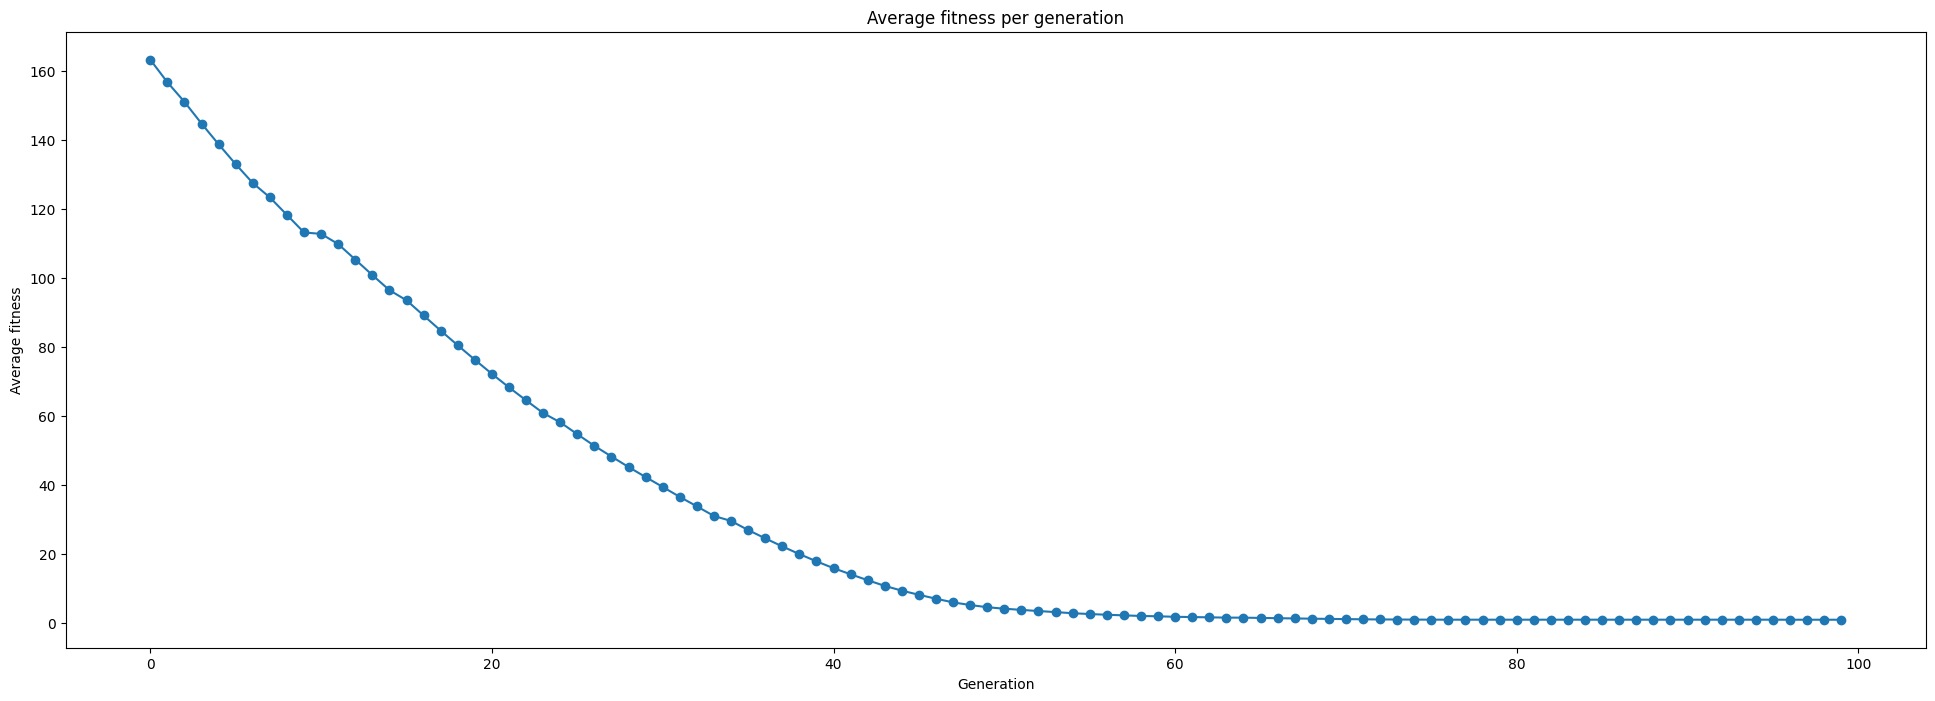

Minimum generation score: 0.98
Best chromossome (Gene: [0 0 0 0 0 0 0 0 0 0], Score: 0.000)


In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,8))
plt.xlabel('Generation')
plt.ylabel('Average fitness')
plt.title('Average fitness per generation')
plt.plot(population_score, marker = "o")
plt.show()

print(f"Minimum generation score: {min(population_score)}")
print(f"Best chromossome {best_chromossome}")